In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from glob import glob
from PIL import Image, ImageDraw, ImageFont
from tqdm import tqdm
import numpy as np
import torch
import json
from collections import Counter

base = '/opt/ml/detection/dataset'
trainroot = os.path.join(base, 'train')
testroot = os.path.join(base, 'test')
resultroot = './results'

if not os.path.isdir(resultroot):
    os.makedirs(resultroot)

In [2]:
train_json = json.load(open(os.path.join(base, 'train.json')))
# print(train_json['annotations'][0])
print(train_json['images'][-1])

is_vis = False
for k in train_json.keys():
    print(f'{k: <14}:\t {len(train_json[k])}')

print('\n  [images]')
all_paths = train_json['images'][-3:]
for path in all_paths:
    print(f'\t{path}')
print(len(train_json['images']))


print('\n  [categories]')
for v in train_json['categories']:
    print(f'\t{v["id"]}:  {v["name"]}')

print('\n  [annotations]')
annots = train_json['annotations'][:3]
for ann in annots:
    print(f'\t{ann}')

annots = train_json['annotations']
cates = []

for v in train_json['categories']:
    cates.append(v['name'])
print(f'\n{cates}')
print(train_json['categories'])

{'width': 1024, 'height': 1024, 'file_name': 'train/4882.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-23 16:20:30', 'id': 4882}
info          :	 6
licenses      :	 1
images        :	 4883
categories    :	 10
annotations   :	 23144

  [images]
	{'width': 1024, 'height': 1024, 'file_name': 'train/4880.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-24 11:25:46', 'id': 4880}
	{'width': 1024, 'height': 1024, 'file_name': 'train/4881.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2021-01-05 11:01:18', 'id': 4881}
	{'width': 1024, 'height': 1024, 'file_name': 'train/4882.jpg', 'license': 0, 'flickr_url': None, 'coco_url': None, 'date_captured': '2020-12-23 16:20:30', 'id': 4882}
4883

  [categories]
	0:  General trash
	1:  Paper
	2:  Paper pack
	3:  Metal
	4:  Glass
	5:  Plastic
	6:  Styrofoam
	7:  Plastic bag
	8:  Battery
	9:  Clothing

  [annotations]
	{'image_id': 0, 'category_id': 0, '

x:  386.20,  244.49
y:  382.23,  217.28
w:  257.50,  204.58
h:  252.24,  200.14
1.2077341859661253
0.0
mean:	 1.2077341859661253
std:	 0.9872334834141009
(-3):	 -1.7539662642761773
(-2):	 -0.7667327808620765
(-1):	 0.22050070255202436
(-0.5):	 0.7141174442590748
(0):	 1.2077341859661253
(0.5):	 1.7013509276731758
(1):	 2.194967669380226
(2):	 3.182201152794327
(3):	 4.169434636208428

(array([14253, 14254, 14255, ..., 15431, 15432, 15433]),)
14843
23144
min:	 0.6412520064205457
mean:	1.2077341859661253
max:	 1.796603627942879


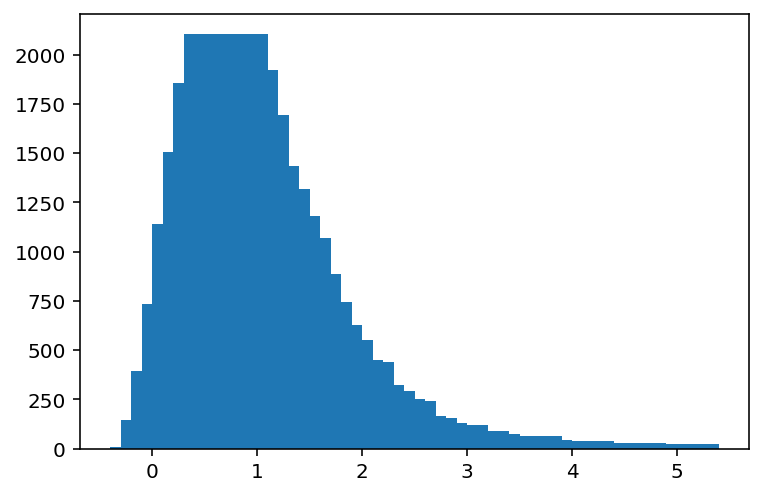

In [3]:
# get dist. of bbox W, H
xs, ys = [], []
ws, hs = [], []
#
for ann in annots:
    x,y,w,h = ann['bbox']
    xs.append(x)
    ys.append(y)
    ws.append(w)
    hs.append(h)

xs = np.array(xs)
ys = np.array(ys)
ws = np.array(ws)
hs = np.array(hs)

print(f'x: {np.mean(xs): .2f}, {np.std(xs): .2f}')
print(f'y: {np.mean(ys): .2f}, {np.std(ys): .2f}')
print(f'w: {np.mean(ws): .2f}, {np.std(ws): .2f}')
print(f'h: {np.mean(hs): .2f}, {np.std(hs): .2f}')


# get dist. of Anchor ratio
anchor_ratio = np.round(hs / ws, 1)
print(np.mean(anchor_ratio))
print(np.min(anchor_ratio))

cnt = Counter()
for anc in anchor_ratio:
    if anc <= 5:
        cnt.update([anc])
    if anc < 0:
        print(anc)

cnts = sorted(cnt.items(), key=lambda x: x[1], reverse=True)
prev_v = 3000
# for k, v in cnts:
#     print(f'{k}:\t {v},\t {prev_v-v}')
#     prev_v = v

# print(cnt.keys())
plt.bar(cnt.keys(), cnt.values())
# print(cnt)

sigma = 1
an_mean = np.mean(anchor_ratio)
an_std = np.std(anchor_ratio)
print(f'mean:\t {np.mean(anchor_ratio)}')
print(f'std:\t {np.std(anchor_ratio)}')

print(f'(-3):\t {an_mean - 3*an_std}')
print(f'(-2):\t {an_mean - 2*an_std}')
print(f'(-1):\t {an_mean - 1*an_std}')
print(f'(-0.5):\t {an_mean - 0.5*an_std}')
print(f'(0):\t {an_mean}')
print(f'(0.5):\t {an_mean + 0.5*an_std}')
print(f'(1):\t {an_mean + 1*an_std}')
print(f'(2):\t {an_mean + 2*an_std}')
print(f'(3):\t {an_mean + 3*an_std}', end='\n\n')

sup = 0.01
anchor_ratio = np.sort(anchor_ratio)
anc_mid_idxs = np.where(anchor_ratio == 1.2)
print(anc_mid_idxs)
mid_idx = int(np.mean(anc_mid_idxs))
print(int(np.mean(anc_mid_idxs)))
print(len(anchor_ratio))

range_size = int( len(anchor_ratio) / 2  * (0.025/100) )
anchor_ratio = hs / ws
anc_range = anchor_ratio[ mid_idx - range_size : mid_idx + range_size]
print(f'min:\t {np.min(anc_range)}')
print(f'mean:\t{an_mean}')
print(f'max:\t {np.max(anc_range)}')


[(0, 3966), (1, 6352), (2, 897), (3, 936), (4, 982), (5, 2943), (6, 1263), (7, 5178), (8, 159), (9, 468)]
Counter({1: 6352, 7: 5178, 0: 3966, 5: 2943, 6: 1263, 4: 982, 3: 936, 2: 897, 9: 468, 8: 159})
[('Battery', 159), ('Clothing', 468), ('Paper pack', 897), ('Metal', 936), ('Glass', 982), ('Styrofoam', 1263), ('Plastic', 2943), ('General trash', 3966), ('Plastic bag', 5178), ('Paper', 6352)]


<BarContainer object of 10 artists>

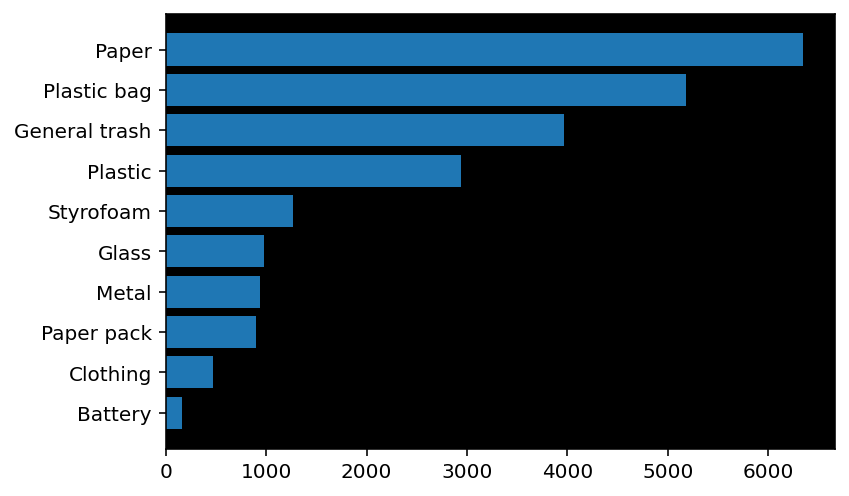

In [4]:
ann_cnt = Counter()
for ann in annots:
    ann_cnt.update([cates[int(ann['category_id'])]])

ape_cnt = Counter()
for ann in annots:
    ape_cnt.update([ann['category_id']])
ape = sorted(ape_cnt.items(), key=lambda x: x[0])
print(ape)
print(ape_cnt)

ann_cnt = sorted(ann_cnt.items(), key = lambda x: x[1], reverse=False)
print(ann_cnt)

xs, ys = [], []
for x, y in ann_cnt:
    xs.append(x)
    ys.append(y)
plt.rcParams['axes.facecolor'] = 'black'
plt.barh(xs, ys)




[(0, 11310), (1, 18595), (2, 3083), (3, 3125), (4, 3068), (5, 8840), (6, 3894), (7, 15096), (8, 1171), (9, 1691)]
Counter({1: 18595, 7: 15096, 0: 11310, 5: 8840, 6: 3894, 3: 3125, 2: 3083, 4: 3068, 9: 1691, 8: 1171})
[('Battery', 1171), ('Clothing', 1691), ('Glass', 3068), ('Paper pack', 3083), ('Metal', 3125), ('Styrofoam', 3894), ('Plastic', 8840), ('General trash', 11310), ('Plastic bag', 15096), ('Paper', 18595)]


<BarContainer object of 10 artists>

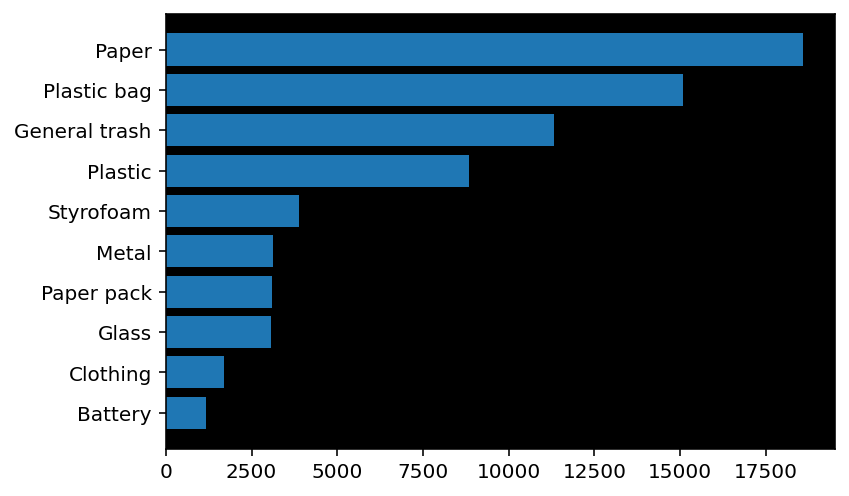

In [5]:
new_ds_path = '/opt/ml/detection/train_Mixaug.json'
new_dataset = json.load(open(new_ds_path))
n_annots = new_dataset['annotations']

ann_cnt = Counter()
for ann in n_annots:
    ann_cnt.update([cates[int(ann['category_id'])]])

ape_cnt = Counter()
for ann in n_annots:
    ape_cnt.update([ann['category_id']])
ape = sorted(ape_cnt.items(), key=lambda x: x[0])
print(ape)
print(ape_cnt)

ann_cnt = sorted(ann_cnt.items(), key = lambda x: x[1], reverse=False)
print(ann_cnt)

xs, ys = [], []
for x, y in ann_cnt:
    xs.append(x)
    ys.append(y)
plt.barh(xs, ys)

[(0, 11695), (1, 17922), (2, 3197), (3, 3579), (4, 3808), (5, 8910), (6, 4289), (7, 15172), (8, 1797), (9, 2011)]
Counter({1: 17922, 7: 15172, 0: 11695, 5: 8910, 6: 4289, 4: 3808, 3: 3579, 2: 3197, 9: 2011, 8: 1797})
[('Battery', 1797), ('Clothing', 2011), ('Paper pack', 3197), ('Metal', 3579), ('Glass', 3808), ('Styrofoam', 4289), ('Plastic', 8910), ('General trash', 11695), ('Plastic bag', 15172), ('Paper', 17922)]


<BarContainer object of 10 artists>

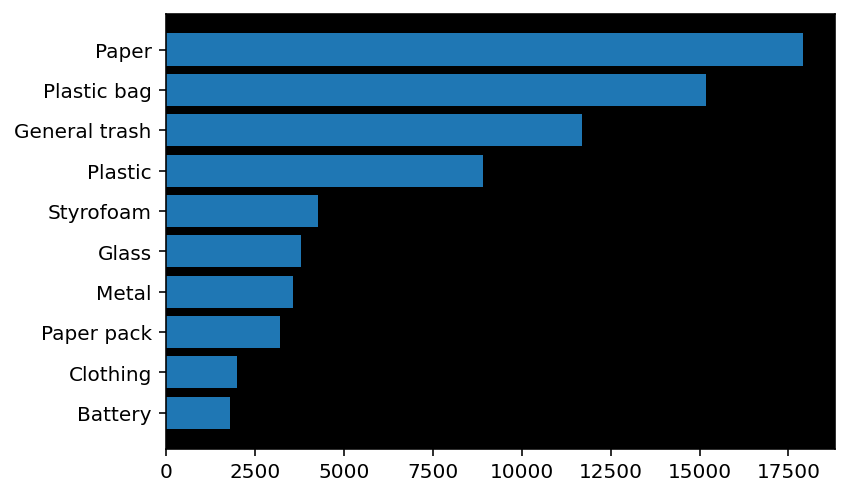

In [6]:
new_ds_path = '/opt/ml/detection/Augmented/datasetMixBgAug3406/train_v1.json'
new_dataset = json.load(open(new_ds_path))
n_annots = new_dataset['annotations']

ann_cnt = Counter()
for ann in n_annots:
    ann_cnt.update([cates[int(ann['category_id'])]])

ape_cnt = Counter()
for ann in n_annots:
    ape_cnt.update([ann['category_id']])
ape = sorted(ape_cnt.items(), key=lambda x: x[0])
print(ape)
print(ape_cnt)

ann_cnt = sorted(ann_cnt.items(), key = lambda x: x[1], reverse=False)
print(ann_cnt)

xs, ys = [], []
for x, y in ann_cnt:
    xs.append(x)
    ys.append(y)
plt.barh(xs, ys)

In [7]:
##
# Class-wise box ratio
class_bbox_ratio = {}
for cls in range(10):
    class_bbox_ratio[cls] = []

APs = [365, 574, 324, 370, 511, 497, 466, 573, 443, 780]

for ann in annots:
    curr_ratio = ann['bbox'][3] / ann['bbox'][2]
    class_bbox_ratio[ann['category_id']].append(curr_ratio)



class_bbox_ratio = sorted(class_bbox_ratio.items(), key=lambda x: len(x[1]), reverse=True)

print('Classes\t\t\t APs\t\t meanBoxRatio')
for idx, (k ,v) in enumerate(class_bbox_ratio):
    print(f'{cates[k]: <15}:\t [{APs[idx]/1000: <5}]\t {np.mean(np.array(v)): .4f}')



Classes			 APs		 meanBoxRatio
Paper          :	 [0.365]	  1.1322
Plastic bag    :	 [0.574]	  1.2840
General trash  :	 [0.324]	  1.2364
Plastic        :	 [0.37 ]	  1.1888
Styrofoam      :	 [0.511]	  1.0622
Glass          :	 [0.497]	  1.6113
Metal          :	 [0.466]	  1.1841
Paper pack     :	 [0.573]	  0.9806
Clothing       :	 [0.443]	  1.2621
Battery        :	 [0.78 ]	  1.2897


In [ ]:
##
# Class-wise box area
class_bbox_area = {}
for cls in range(10):
    class_bbox_ratio[cls] = []

APs = [365, 574, 324, 370, 511, 497, 466, 573, 443, 780]

for ann in annots:
    curr_ratio = ann['bbox'][3] / ann['bbox'][2]
    class_bbox_ratio[ann['category_id']].append(curr_ratio)



class_bbox_ratio = sorted(class_bbox_ratio.items(), key=lambda x: len(x[1]), reverse=True)

print('Classes\t\t\t APs\t\t meanBoxRatio')
for idx, (k ,v) in enumerate(class_bbox_ratio):
    print(f'{cates[k]: <15}:\t [{APs[idx]/1000: <5}]\t {np.mean(np.array(v)): .4f}')



In [12]:
ratio = np.array(ys) / np.max(ys)
ratio = 1-ratio
print(ratio)

[0.89973217 0.88779154 0.82161589 0.80030131 0.78752371 0.76068519
 0.50284566 0.34745006 0.1534427  0.        ]


In [13]:
ann_cnt = Counter()
for ann in annots:
    ann_cnt.update([ann['category_id']])

ann_cnt = sorted(ann_cnt.items(), key=lambda x: x[0])
print(ann_cnt)
ann_cnt = [x[1] for x in ann_cnt]
ratio = np.array(ann_cnt)
ratio = np.log(ratio + 1.1)
ratio = ratio / np.sum(ratio)
ratio = 1 - (ratio / np.max(ratio))
print(ratio)

[(0, 3966), (1, 6352), (2, 897), (3, 936), (4, 982), (5, 2943), (6, 1263), (7, 5178), (8, 159), (9, 468)]
[0.05377684 0.         0.22341946 0.21856505 0.21309257 0.08783444
 0.18438257 0.02333203 0.42035245 0.2975873 ]


<BarContainer object of 10 artists>

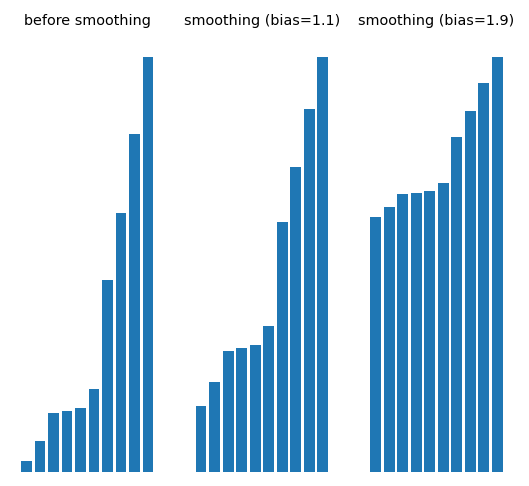

In [9]:
def minmax(arr):
    arr = arr / np.sum(arr)
    return arr

plt.rc('font', size=6)
# plt.axis('off')
fig = plt.figure()
ax1 = fig.add_subplot(1,4,1)
ax2 = fig.add_subplot(1,4,2)
ax3 = fig.add_subplot(1,4,3)



ratio = np.array(ys) / np.max(ys)
ax1.set_title('before smoothing')
ax1.axis('off')
ax1.bar([x for x in range(len(ratio))], ratio)
# print(ratio)

res = minmax(np.log(ratio + 1.1))
ax2.set_title('smoothing (bias=1.1)')
ax2.axis('off')
ax2.bar([x for x in range(len(res))], res)

res = minmax(np.log(ratio + 1.9))
ax3.set_title('smoothing (bias=1.9)')
ax3.axis('off')
ax3.bar([x for x in range(len(res))], res)


In [7]:
cls_arr = []
for idx, rat in enumerate(ratio):
    for vol in range(int(rat*5000)):
        cls_arr.append(idx)
    
cls_cnt = Counter(cls_arr)
print(cls_cnt)

Counter({9: 659, 8: 618, 7: 573, 6: 532, 5: 459, 4: 445, 3: 443, 2: 441, 1: 420, 0: 405})


In [45]:
font = ImageFont.truetype('./ubuntu.regular.ttf', 15)
color_group = {'General trash': 'orange', 'Paper': 'white', 'Paper pack': 'ivory', 'Metal': 'dimgrey', 'Glass': 'dodgerBlue', 'Plastic': 'darkolivegreen', 'Styrofoam': 'khaki', 'Plastic bag': 'Teal', 'Battery': 'lime', 'Clothing': 'fuchsia'}

def drawbox(draw, cate, pt1, pt2):
    draw.rectangle((pt1, pt2), outline=color_group[cate], width=3)
    backrec = (pt1[0]+90, pt1[1]+15)
    # draw.rectangle((pt1, backrec), outline=(0,0,0), fill=True)
    draw.text(pt1, cate, (255,255,255), font=font, backrec=True)

In [46]:
###
# visualizing annots

train_paths = glob(os.path.join(trainroot, '*'))
test_paths = glob(os.path.join(testroot, '*'))
print(f'{len(train_paths)} {len(test_paths)}')


images = train_json['images']
for image in tqdm(images):
    img = Image.open(os.path.join(base, image['file_name']))
    draw = ImageDraw.Draw(img)
    for ann in annots:
        if ann['image_id'] == image['id']:
            x,y,w,h = ann['bbox']
            pt1, pt2 = (x,y), (x+w, y+h)
            drawbox(draw, cates[ann['category_id']], pt1, pt2)
            img.save(os.path.join(resultroot, image['file_name'].split('/')[-1]))

4883 4871


 26%|██▌       | 1270/4883 [04:37<13:09,  4.58it/s]


KeyboardInterrupt: 